In [1]:
import torch.nn as nn
def _xavier_init(conv: nn.Module):
    for layer in conv.modules():
        if isinstance(layer, nn.Conv2d):
           torch.nn.init.xavier_uniform_(layer.weight)
           if layer.bias is not None:
              torch.nn.init.constant_(layer.bias, 0.0)





In [2]:
import torch.nn as nn
import torch
class ssd_classification_head(nn.Module):
  def __init__(self, num_classes=2):
      super(ssd_classification_head, self).__init__()
      self.num_classes = num_classes
      num_anchors = [4, 6, 6, 6, 4, 4]
      in_channels = [512, 1024, 512, 256, 256, 256]
      self.cls_layers = nn.ModuleList()
      for channels, anchors in zip(in_channels, num_anchors):
        self.cls_layers.append(nn.Conv2d(channels, num_classes * anchors, kernel_size=3, padding=1))
      _xavier_init(self.cls_layers)
  def forward(self, x):
      all_results = []
      for i, features in enumerate(x):
          results = self.cls_layers[i](features)
          N, _, H, W = results.shape
          
          results = results.view(N, -1, self.num_classes, H, W)
          results = results.permute(0,3,4,1,2)
          results = results.reshape(N, -1, self.num_classes)
          all_results.append(results)
      return torch.cat(all_results, dim=1)


In [3]:
import torch.nn as nn 
import torch
class ssd_regression_head(nn.Module):
  def __init__(self, ):
      super(ssd_regression_head, self).__init__()
      num_anchors = [4, 6, 6, 6, 4, 4]
      in_channels = [512, 1024, 512, 256, 256, 256]
      self.reg_layers = nn.ModuleList()
      for channels, anchors in zip(in_channels, num_anchors):
          self.reg_layers.append(nn.Conv2d(channels, 4*anchors, kernel_size=3, padding=1))
      _xavier_init(self.reg_layers)
  def forward(self, x):
      all_results = []
      for i, features in enumerate(x):
          result = self.reg_layers[i](features)
          N, _, H, W = result.shape
          result = result.view(N,-1, 4, H, W)
          result = result.permute(0,3,4,1,2)
          result = result.reshape(N, -1, 4)
          all_results.append(result)
      return torch.cat(all_results, dim=1)


In [4]:
import torch.nn.init as init
from collections import OrderedDict
import torch.nn as nn
from torchvision.models.vgg import vgg16
class ssd_network(nn.Module):
  def __init__(self, ):
      super(ssd_network, self).__init__()
      backbone = vgg16(pretrained=True)
      for i, param in enumerate(backbone.parameters()):
          param.requires_grad = False
          
      maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
      backbone.features[16] = maxpool2d
      self.features = backbone.features[:-8]
      
    
      fc = nn.Sequential(
          nn.MaxPool2d(kernel_size=3, stride=1,padding=1, ceil_mode=False),
          nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=6, dilation=6),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
          nn.ReLU(inplace=True))
      _xavier_init(fc)
      
      cut_layers_with_fc = nn.Sequential(*backbone.features[23:-1], fc)
      for param in cut_layers_with_fc.parameters():
          param.requires_grad = True

      extra = nn.ModuleList([
          nn.Sequential(
              nn.Conv2d(1024,256, kernel_size=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
              nn.ReLU(inplace=True)
          ),
          nn.Sequential(
              nn.Conv2d(512,128, kernel_size=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(128,256, kernel_size=3, padding=1, stride=2),
              nn.ReLU(inplace=True)
          ),
          nn.Sequential(
              nn.Conv2d(256,128,kernel_size=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(128, 256, kernel_size=3),
              nn.ReLU(inplace=True)
          ),
          nn.Sequential(
              nn.Conv2d(256, 128, kernel_size=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(128, 256, kernel_size=3),
              nn.ReLU(inplace=True)
          ),
        ])
      _xavier_init(extra)
      extra.insert(0, cut_layers_with_fc)

      self.extra = extra
      
      
  def forward(self, x):
      x = self.features(x)
      
      output = [x]
      for block in self.extra:
          x = block(x)
          output.append(x) 
      return OrderedDict([ (str(i), v) for i, v in enumerate(output) ])
      
  




In [5]:

import torch
import torch.nn.functional as F
class main_ssd(nn.Module):
    def __init__(self, ssd_network: nn.Module, 
                 classification_head: nn.Module,
                 regression_head: nn.Module,
                 default_boxes: nn.Module):
        super(main_ssd, self).__init__()
        self.default_boxes = default_boxes
        self.ssd_network = ssd_network
        self.classification_head = classification_head
        self.regression_head = regression_head
        self.weights = [1.0,1.0,1.0,1.0]
        loss_weight = torch.tensor([1.0, 1.0])
        self.classifier = nn.CrossEntropyLoss(weight=loss_weight, reduction='mean')

    def forward(self, images, gboxes):
        features = self.ssd_network(images)
        features = list(features.values())
        pred_cls_scores = self.classification_head(features)
        
        pred_offsets = self.regression_head(features)
        dboxes = self.default_boxes(images, features)
        valid_dboxes = torch.where((dboxes[:,0]>=0)&(dboxes[:,1]>=0)&(dboxes[:,2]>=0)&(dboxes[:,3]>=0) &
                                   (dboxes[:,2]<=300) & (dboxes[:,3]<=300) )
        valid_dboxes = torch.where( ( (dboxes[valid_dboxes][:,3] - dboxes[valid_dboxes][:,1])>=40) &
                                   (( dboxes[valid_dboxes][:,2] - dboxes[valid_dboxes][:,0] )>=40))

        dboxes = dboxes[valid_dboxes]
        
        

        assigned_labels, assigned_boxes = assign_dboxes_to_gt_bboxes(dboxes, gboxes)
        '''
        for label, boxes in zip(assigned_labels, assigned_boxes):
            im = images[0].to(torch.device('cpu')).numpy().transpose(1,2,0).copy()
            positives = torch.where(label==1)[0]
            print('assined lab', label)
            print('assinged_boxes', boxes[positives])
            for box in boxes[positives]:
              x1 = int(box[0])
              y1 = int(box[1])
              x2 = int(box[2])
              y2 = int(box[3])
              cv2.rectangle(im, (x1, y1),(x2, y2), (0,255,0),2)
            plt.imshow(im)
            print(n)
        '''
           
        offsets = encode_boxes(assigned_boxes, dboxes.unsqueeze(0), self.weights)
        
        

        dboxes_candidates, positive_cands = self.Select_Training_dboxes(assigned_labels, pred_cls_scores, valid_dboxes)

        Loss = self.loss(pred_offsets, offsets, pred_cls_scores,
                         assigned_labels, dboxes_candidates, positive_cands, valid_dboxes )
        
        return Loss

    def Select_Training_dboxes(self, labels, pred_scores, valid_dboxes):
        contributed_dboxes, positives_candidates = [], []
        for indx, label_batch in enumerate(labels):
            
            
            positive_labels = torch.where(label_batch>0)[0]
            negative_labels = torch.where(label_batch==0)[0]
            

            if positive_labels.numel() > 16:
               
               pre_score_process = torch.gather(pred_scores[indx][valid_dboxes][positive_labels], 1, label_batch.to(torch.long).view(-1,1)[positive_labels])
               
               _, hard_mining_positive_indices = torch.topk( pre_score_process.view(-1), k=16, largest=True)

               _, hard_mining_negative_indices = torch.topk( pred_scores[indx][valid_dboxes][negative_labels][:,0].view(-1), k=240, largest=False)

               contributed_dboxes.append(torch.cat( (positive_labels[hard_mining_positive_indices],
                                                   negative_labels[hard_mining_negative_indices]) ))
               positives_candidates.append(positive_labels[hard_mining_positive_indices])

            else:
               _,hard_mining_negative_indices = torch.topk(pred_scores[indx][valid_dboxes][negative_labels][:,0].view(-1), k = 256 - positive_labels.numel(), largest=False)
               contributed_dboxes.append(torch.cat( (positive_labels, negative_labels[hard_mining_negative_indices]) ))
               positives_candidates.append(positive_labels)
        
        return contributed_dboxes, positives_candidates

   
    def loss(self, pred_offsets, offsets, pred_cls, labels,
             dboxes_candidates, positive_cands, valid_dboxes):

        pred_offsets = torch.cat((pred_offsets[0][valid_dboxes][positive_cands[0]], pred_offsets[1][valid_dboxes][positive_cands[1]]))
        choosen_offsets = torch.cat((offsets[0][positive_cands[0]], offsets[1][positive_cands[1]]))

        
        choosen_pred_cls = torch.cat( (pred_cls[0][valid_dboxes][dboxes_candidates[0]], 
                                       pred_cls[1][valid_dboxes][dboxes_candidates[1]]) )
        
        choosen_labels = torch.cat( (labels[0][dboxes_candidates[0]],
                                     labels[1][dboxes_candidates[1]]) ).to(torch.long)
        
        num_classes = 2
        choosen_labels = torch.eye(num_classes).to(device=choosen_labels.device)[choosen_labels]
        
        classifier = self.classifier(choosen_pred_cls, choosen_labels)
        bbox_regressor = F.smooth_l1_loss(pred_offsets, choosen_offsets, 
                                          reduction='sum')/max(1, pred_offsets.numel())
        
        loss = classifier + bbox_regressor
        
        return {'loss':loss, 'bbox_regressor':bbox_regressor, 'classifier':classifier}

                                    





In [6]:
import torch
import time 
from typing import List 
@torch.jit.script
def calc_iou(dboxes, gt_boxes):
    dboxes_area = (dboxes[:, 2] - dboxes[:,0])*(dboxes[:,3] - dboxes[:,1])
    gt_area = (gt_boxes[:,2] - gt_boxes[:,0])*(gt_boxes[:,3] - gt_boxes[:,1])
    upper_left_intersection = torch.max(dboxes[:,:2].unsqueeze(1), gt_boxes[:,:2])
    lower_right_intersection = torch.min(dboxes[:,2:].unsqueeze(1), gt_boxes[:,2:])
    intersection_dimension = (lower_right_intersection - upper_left_intersection).clamp(min=0)
    intersection_area = intersection_dimension[:,:,0]*intersection_dimension[:,:,1]
    union_areas = dboxes_area.unsqueeze(1) + gt_area - intersection_area
    return intersection_area/union_areas
@torch.jit.script
def assign_dboxes_to_gt_bboxes(dboxes: torch.Tensor, gt_bboxes: List[torch.Tensor]):
    all_labels, assigned_bbox = [], []
    for gt_boxes_batch in gt_bboxes:
        ious = calc_iou(dboxes, gt_boxes_batch[:,1:])
        labels = torch.empty(len(dboxes), dtype=torch.float32, device=dboxes.device).fill(-1)
        assigned_boxes = torch.zeros_like(dboxes, dtype=dboxes.dtype,
                                          device=dboxes.device)
        
        gt_labels = gt_boxes_batch[:,0].unsqueeze(0)
        max_ious, indices = torch.max(ious, dim=1)
      
        indices_iou_threshold_positive=torch.where(max_ious>=0.5)[0]

        final_indices = indices[indices_iou_threshold_positive]
        labels[indices_iou_threshold_positive] = gt_labels[:, final_indices].view(-1)
        assigned_boxes[indices_iou_threshold_positive] = gt_boxes_batch[:,1:][final_indices]
        back_ground_indices = torch.where(max_ious<0.2)[0]
        labels[back_ground_indices] = torch.tensor([0], dtype=gt_labels.dtype, device=dboxes.device)
        all_labels.append(labels)
        assigned_bbox.append(assigned_boxes)
        
    return torch.stack(all_labels, dim=0), torch.stack(assigned_bbox, dim=0)



In [9]:
import torch
import math 
def encode_boxes(gboxes, dboxes, weights):
    wx = weights[0]
    wy = weights[1]
    ww = weights[2]
    wh = weights[3]
    

    dboxes_x1 = dboxes[:,:,0]
    dboxes_y1 = dboxes[:,:,1]
    dboxes_x2 = dboxes[:,:,2]
    dboxes_y2 = dboxes[:,:,3]

    dboxes_width = dboxes_x2 - dboxes_x1
    dboxes_height = dboxes_y2 - dboxes_y1
    dboxes_ctr_x = dboxes_x1 + 0.5 * dboxes_width
    dboxes_ctr_y = dboxes_y1 + 0.5 * dboxes_height

    gboxes_x1 = gboxes[:,:,0]
    gboxes_y1 = gboxes[:,:,1]
    gboxes_x2 = gboxes[:,:,2]
    gboxes_y2 = gboxes[:,:,3]

    gboxes_width = gboxes_x2 - gboxes_x1
    gboxes_height = gboxes_y2 - gboxes_y1
    gboxes_ctr_x = gboxes_x1 + 0.5 * gboxes_width
    gboxes_ctr_y = gboxes_x2 + 0.5 * gboxes_height

    

    targets_dx = wx * (gboxes_ctr_x - dboxes_ctr_x)/dboxes_width
    targets_dy = wy * (gboxes_ctr_y - dboxes_ctr_y)/dboxes_height
    targets_dw = ww * torch.log(gboxes_width/dboxes_width)
    targets_dh = wh * torch.log(gboxes_height/dboxes_height)
    
    targets = torch.cat((targets_dx.unsqueeze(2), targets_dy.unsqueeze(2),
                         targets_dw.unsqueeze(2), targets_dh.unsqueeze(2)), dim=2)
    
    return targets

def decode_boxes(predicted_boxes, dboxes, weights):
    wx = weights[0]
    wy = weights[1]
    ww = weights[2]
    wh = weights[3]

    dboxes_x1 = dboxes[:,:,0]
    dboxes_y1 = dboxes[:,:,1]
    dboxes_x2 = dboxes[:,:,2]
    dboxes_y2 = dboxes[:,:,3]

    dboxes_width = dboxes_x2 - dboxes_x1 
    dboxes_height = dboxes_y2 - dboxes_y1
    dboxes_ctr_x = dboxes_x1 + 0.5 * dboxes_width
    dboxes_ctr_y = dboxes_y1 + 0.5 * dboxes_height

    pboxes_x = predicted_boxes[:,:,0]/wx
    pboxes_y = predicted_boxes[:,:,1]/wy
    pboxes_w = predicted_boxes[:,:,2]/ww
    pboxes_h = predicted_boxes[:,:,3]/wh

    pboxes_w = torch.clamp(pboxes_w, max=math.log(1000./16))
    pboxes_h = torch.clamp(pboxes_h, max=math.log(1000./16))

    pboxes_ctr_x = pboxes_x * dboxes_width + dboxes_ctr_x
    pboxes_ctr_y = pboxes_y * dboxes_height + dboxes_ctr_y
    pboxes_w = torch.exp(pboxes_w) * dboxes_width
    pboxes_h = torch.exp(pboxes_h) * dboxes_height

    target_x1 = pboxes_ctr_x - 0.5 * pboxes_w
    target_y1 = pboxes_ctr_y - 0.5 * pboxes_h
    target_x2 = pboxes_ctr_x + 0.5 * pboxes_w
    target_y2 = pboxes_ctr_y + 0.5 * pboxes_h

    targets = torch.cat( (target_x1.unsqueeze(2), target_y1.unsqueeze(2),
                          target_x2.unsqueeze(2), target_y2.unsqueeze(2)), dim=2)
    
    return targets






In [10]:
import torch.nn as nn
import math
import torch
class default_boxes(nn.Module):
  def __init__(self, aspect_ratios=[[2],[2,3],[2,3],[2,3],[2],[2]], 
               scales=[0.07,0.15,0.33,0.51,0.69,0.87,1.05], 
               steps=[8,16,32,64,100,300], clip=True):
    super().__init__()
    self.aspect_ratios = aspect_ratios
    self.steps = steps
    self.clip = clip
    num_outputs = len(aspect_ratios)
    self.scales = scales
    self.wh_pairs = self.generate_wh_pairs(num_outputs)

  def generate_wh_pairs(self, num_outputs, dtype=torch.float32, device = torch.device('cpu') ):
    _wh_pairs = []
    for k in range(num_outputs):
      s_K = self.scales[k]
      s_prime_k = math.sqrt(self.scales[k]*self.scales[k+1])
      wh_pairs = [[s_K, s_K], [s_prime_k, s_prime_k]]

      for ar in self.aspect_ratios[k]:
        sq_ar = math.sqrt(ar)
        w = self.scales[k]*sq_ar
        h = self.scales[k]/sq_ar
        wh_pairs.extend([[w, h],[h,w]])
      
      _wh_pairs.append(torch.as_tensor(wh_pairs, dtype=dtype, device=device))
    
    return _wh_pairs

  def num_anchors_per_location(self):
    return [2+2*len(r) for r in self.aspect_ratios]
  
  def _grid_default_boxes(self, grid_sizes, image_size, dtype=torch.float32):
    default_boxes = []
    for k, f_k in enumerate(grid_sizes):
        if self.steps is not None:
          x_f_k = image_size[1]/ self.steps[k]
          y_f_k = image_size[0]/ self.steps[k]
        else:
          y_f_k, x_f_k = f_k
        shifts_x = ((torch.arange(0, f_k[1]) + 0.5)/x_f_k).to(dtype=dtype)
        shifts_y = ((torch.arange(0, f_k[0]) + 0.5)/y_f_k).to(dtype=dtype)
        shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        shift_x = shift_x.reshape(-1)
        shift_y = shift_y.reshape(-1)

        shifts = torch.stack((shift_x, shift_y) * len(self.wh_pairs[k]), dim=-1).reshape(-1,2)
        wh_pair = self.wh_pairs[k].clamp(min=0, max=1) if self.clip else self.wh_pairs[k]
        wh_pairs = wh_pair.repeat((f_k[0] * f_k[1]), 1)
        default_box = torch.cat((shifts, wh_pairs), dim=1)
        default_boxes.append(default_box)
    return torch.cat(default_boxes, dim=0)
  def forward(self, images, feature_maps):
    grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]
    image_sizes = images.shape[-2:]
    
    dtype, device = feature_maps[0].dtype, feature_maps[0].device
    default_boxes = self._grid_default_boxes(grid_sizes, image_sizes, dtype=dtype)
    default_boxes = default_boxes.to(device)
    

    dboxes = []
    x_y_size = torch.tensor([image_sizes[1], image_sizes[0]], device=default_boxes.device)
    
    for _ in range(1):
        dboxes_in_image = default_boxes
        dboxes_in_image = torch.cat([
            (dboxes_in_image[:, :2] - 0.5 * dboxes_in_image[:, 2:]) * x_y_size,
            (dboxes_in_image[:, :2] + 0.5 * dboxes_in_image[:,2:]) * x_y_size,
        ],
        -1,
        )
        

    return dboxes_in_image





In [11]:
from tqdm import tqdm 
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import torch
import numpy as np
import time 
from PIL import Image

def train_epocs(model, optimizer, date_loader, device, epochs=10, training_state=True):
    for epoch in range(epochs):
        total = 6
        sum_loss  = 0
        sum_cls_loss = 0
        sum_loc_loss = 0
        iteration_num = 0
        for data in tqdm(data_loader):
            images = data[0].to(device)
            
            targets = [boxes.to(device) for boxes in data[1]]
            
            batch_length = len(images)
            if not training_state:
              with torch.no_grad():
                model.eval()
                output = model(images, targets)
            else:
              model.train()
              output = model(images, targets)

            Final_loss = output['loss']

            if training_state:
               optimizer.zero_grad()
               Final_loss.backward()
               optimizer.step()
            
            iteration_num += 1
            total += batch_length
            sum_loss += output['loss']
            sum_cls_loss += output['classifier']
            sum_loc_loss += output['bbox_regressor']
            if iteration_num % 100 ==0 :
               average_loss = sum_loss/total
               average_cls_loss = sum_cls_loss/total
               average_loc_loss = sum_loc_loss/total
               
               print("loss %.4f loc_loss %.4f cls_loss %.4f "%(average_loss, average_loc_loss, average_cls_loss ))
               total = 0.0
               sum_loss = 0.0
               sum_cls_loss = 0.0
               sum_loc_loss = 0.0
        average_loss = sum_loss/total
        average_cls_loss = sum_cls_loss/total
        average_loc_loss = sum_loc_loss/total  
        print("loss %.4f loc_loss %.4f cls_loss %.4f"%(average_loss, average_loc_loss, average_cls_loss))
    return model










In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model = main_ssd(ssd_network(), ssd_classification_head(), ssd_regression_head(), default_boxes()).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)




cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ssd_model.pth')




In [24]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/ssd_model.pth', map_location=device))






<All keys matched successfully>

In [ ]:
train = train_epocs(model, optimizer, data_loader, device, training_state=True)




In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
!unzip /content/gdrive/MyDrive/wider_face_split.zip



Archive:  /content/gdrive/MyDrive/wider_face_split.zip
   creating: wider_face_split/
  inflating: wider_face_split/readme.txt  
  inflating: wider_face_split/wider_face_test.mat  
  inflating: wider_face_split/wider_face_test_filelist.txt  
  inflating: wider_face_split/wider_face_train.mat  
  inflating: wider_face_split/wider_face_train_bbx_gt.txt  
  inflating: wider_face_split/wider_face_val.mat  
  inflating: wider_face_split/wider_face_val_bbx_gt.txt  


In [ ]:
!unzip /content/gdrive/MyDrive/WIDER_train.zip

In [15]:
from PIL import Image
import torchvision
import numpy as np
import cv2
import torch 

class LoadDataSet(torch.utils.data.Dataset):
      def __init__(self, annotation_path, images_path, transforms=None):
          self.images_path_list = images_path
          self.annotations_path_list = annotation_path
          self.transform = transforms
          self.size = len(self.images_path_list)
          print(self.size)
      def __getitem__(self, idx):
        Transform = torchvision.transforms.Normalize(mean=[0.485, 0.456,0.406],
                                                     std=[0.229, 0.224, 0.225])
        
        img_path = '/content/WIDER_train/images/'+ self.images_path_list[idx]
        gt_boxes = self.annotations_path_list[idx]
        img = Image.open(img_path)
        img = np.asarray(img)
        img_size = img.shape
        image = cv2.resize(img/255, (300,300), interpolation=cv2.INTER_AREA)
        image = torch.as_tensor(image, dtype=torch.float32).permute(2,0,1)
        image = Transform(image)
        scalar = torch.tensor([1, 300/img_size[1], 300/img_size[0], 300/img_size[1], 300/img_size[0]], dtype=torch.float32)

        boxes = []
        for box in gt_boxes:
            scaled_box = torch.tensor(box, dtype=torch.float32) * scalar
            boxes.append(scaled_box)

        boxes = torch.stack(boxes)
        return image, boxes
      def __len__(self):
          return self.size
  
def collate_fn(batch):
    images = []
    boxes = []
    for data in batch:
        images.append(data[0])
        boxes.append(data[1])
    return torch.stack(images, dim=0), boxes






In [19]:
file = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
lista = []
inside_list = []
names = []
triger = 0

for idx, line in enumerate(file.readlines()):
    if line[-4:]=="jpg\n":
       names.append(line[:-1])
       if (inside_list==[] or triger==1) and idx!=0:
          names.pop(len(names)-2)
          inside_list=[]
          triger = 0
          continue
       if idx!=0 and inside_list!=[]:
          lista.append(inside_list)
          inside_list = []

    if line[-4:]!="jpg\n" and len(line)>15:
       num_list = line.strip()
       num_str = num_list.split()
       x1 = int(num_str[0])
       y1 = int(num_str[1])
       x2 = int(num_str[0]) + int(num_str[2])
       y2 = int(num_str[1]) + int(num_str[3])
       if num_str[2]!='0' and num_str[3]!='0' and num_str[7]!='1' and (x2-x1)>80 and (x2-x1)<400 and (y2-y1)>80 and (y2-y1)<400:
          array_int = [1, x1, y1, x2, y2]
          inside_list.append(array_int)
       else:
         triger=1
    if idx==185183:
       if inside_list!=[] and triger==0:
          lista.append(inside_list)
       elif inside_list==[] and triger==1:
          names.pop()


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset = LoadDataSet(annotation_path=lista, images_path=names, transforms=None)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, drop_last=True)








3802


Data Visualization

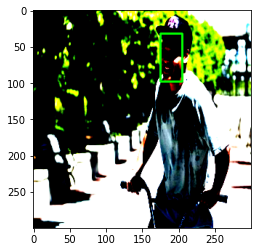

In [23]:
import matplotlib.pyplot as plt
for images, annotations in data_loader:
    img = images[0].numpy().transpose(1,2,0).copy()
    for box in annotations[0]:
        x1 = int(box[1])
        y1 = int(box[2])
        x2 = int(box[3])
        y2 = int(box[4])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.imshow(img)
    break





